In [1]:
%pip install git+https://github.com/huggingface/diffusers

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-d7og6ub9
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-d7og6ub9
  Resolved https://github.com/huggingface/diffusers to commit 4c4fe042a7f718f30f6bd897b967ff800e035347
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.5 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.20.0.dev0-py3-none-any.whl size=1325750 sha256=3b1983d7f555869b25d4fb3ba54d3e68a98b6e1f8ebddf71e5767ac83cb51fe8
  Stored in directory: /tmp/pip-ephem-wheel-cache-c7cm2tqu/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diffusers


In [4]:
%pip install accelerate>=0.16.0 torchvision transformers>=4.25.1 ftfy tensorboard Jinja2

In [5]:
%pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 9.3 MB/s eta 0:00:00


In [6]:
!accelerate config default

2023-08-03 08:21:05.418674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [7]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir,
    repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/content/dog'

In [8]:
MODEL_NAME="runwayml/stable-diffusion-v1-5"
INSTANCE_DIR="dog"
OUTPUT_DIR="saved-model"

In [9]:
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  --validation_prompt="A photo of sks dog in a bucket" \
  --validation_epochs=50 \
  --seed="0"

2023-08-03 08:29:51.181082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-03 08:29:55.822787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
08/03/2023 08:29:59 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'dynamic_thresholding_ratio', 'sample_max_value', 'clip_sample_range', 'thresholding', 'variance_type', 'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
{'scaling_factor', 'force_upcast'} was not found in config. Values will be initialized to default values.
{'timestep_post_act', 'addition_time_embed_dim', 'upcast_attention', 'time_embedding_act_fn', 'num_attention_h

In [10]:
import torch

In [11]:
from diffusers import StableDiffusionPipeline

In [12]:
model_base = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [13]:
pipe.unet.load_attn_procs("saved-model")

In [14]:
pipe.to("cuda")

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.20.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [15]:
image_with_half_weights = pipe(

    "A picture of a sks dog in a bucket.",

    num_inference_steps=25,

    guidance_scale=7.5,

    cross_attention_kwargs={"scale": 0.5},

).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

In [23]:
image_with_75_lora_weights = pipe(

    "A picture of a sks dog in a bucket.",

    num_inference_steps=25,

    guidance_scale=7.5,

    cross_attention_kwargs={"scale": 0.75},

).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
image_with_75_lora_weights.save("bucket-dog75%.png")

In [16]:
image_with_half_weights.save("bucket-dog.png")

In [17]:
image_with_full_lora_weights = pipe("A picture of a sks dog in a bucket.", num_inference_steps=25, guidance_scale=7.5).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

In [18]:
image_with_full_lora_weights.save("bucket-dog1.png")

In [21]:
from IPython.display import Image, display

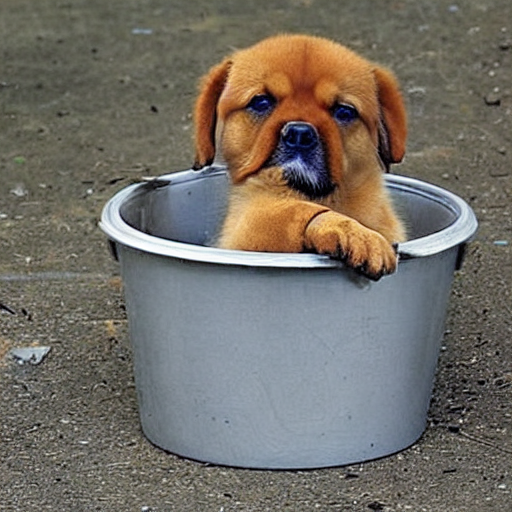

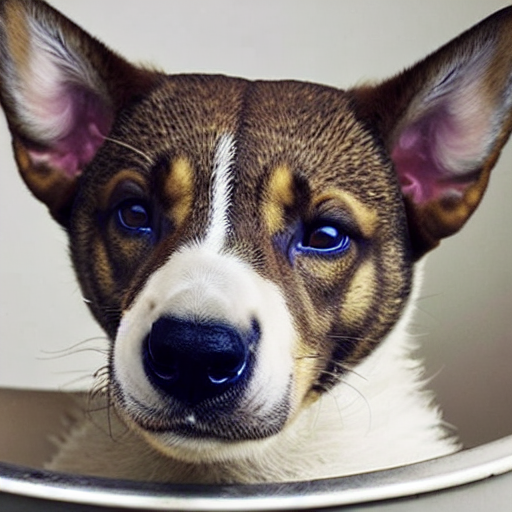

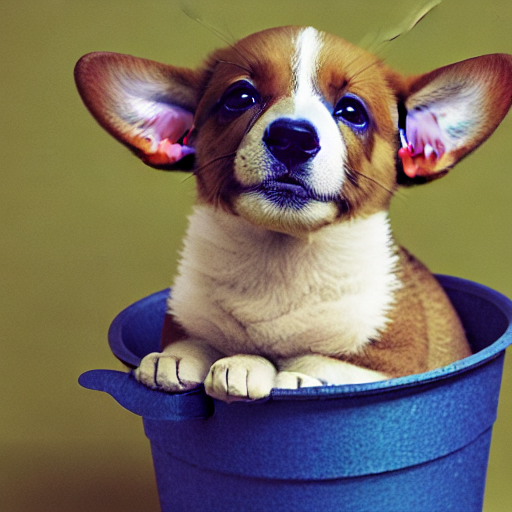

In [25]:
display(Image("bucket-dog.png"))
display(Image("bucket-dog75%.png"))
display(Image("bucket-dog1.png"))